# Node Clustering in Graphs

This program performs clustering by embedding given graph using different embedding techniques. Three different embeddings are utilised before performing K-means clustering - text embedding using `sklearn` TF-IDF vectoriser, matrix factorisation embedding using laplacian matrix, and Node2Vec embedding using `node2vec`. The structure of the Task 2 is as follow: 

* Loading the Data using `pandas`
    * Extract Edges & Nodes Info
    * Extract Attributes of Nodes - Doc Names
    * Extract Labels
        * Understanding the Labels
* Inspecting the Graph
    * Basic Information of the graph 
    * Statistical Summary of Degrees of Nodes 
    * K-cores
* Model Building 
    * Model 1. K-Means Clustering with Matrix Factorisation Embedding 
    * Model 2. K-Means Clustering with Text Embedding 
    * Model 3. K-Means Clustering with Node2Vec Embedding 
* Evaluating the Model using F-1 Score, Recall, Precision, and NMI
    

In [4]:
import scipy as sp
import scipy.sparse.linalg as linalg
import scipy.cluster.hierarchy as hr
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
import sklearn.utils as utils
import sklearn.linear_model as linear_model
import networkx as nx
import seaborn as sns
from matplotlib import pyplot as plt
import re
from sklearn.metrics import * 
import random
from node2vec import Node2Vec
from sklearn.manifold import TSNE
import os
import pandas as pd
import numpy as np
from nltk.corpus import stopwords 
from nltk.tokenize import RegexpTokenizer
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer 

## Extract Edges & Nodes Info

In [5]:
adjedges_handle = open('adjedges.txt','r').readlines()
# read in the file 'adjedges'
# each line is an element within a list 

adjedges = list(map(lambda x: x.rstrip(' \n'),adjedges_handle))
# strip out \n at the end of each line 

In [6]:
adjedges[:10]

['12828558',
 '66779408',
 '38902949 38998399',
 '33450563 26547200',
 '57470294 20968604',
 '12016981',
 '59453341',
 '54791317 9564967 14589786',
 '38124547',
 '44569330']

Each node is the first element of a line, and the ones standing alone in each line is the ones without any neighbours.

In [7]:
nodes_neighbours = dict()
# the dictionary to hold all the nodes in adjedges and their neighbours
# the key is each node, and the value is the neighbour nodes in a list

for i in adjedges: 
# for each line from the file read in 

    nodes = i.split()
    # split the line with white space 
    # the first element in the array returned is the main node 
    # the rest is its adjacent neighbours 
    
    nodes = list(map(lambda x: int(x), nodes))
    # convert the nodes from strings to integer arrays 
    
    if len(nodes) == 1: 
    # if the nodes array only have one element
        nodes_neighbours[nodes[0]] = []
        # no neighbours recorded 
        
    elif len(nodes) > 1: 
    # if the nodes array have more than one element 
        nodes_neighbours[nodes[0]] = nodes[1:]
        # put all the neighbours into a list 
        
    elif len(nodes) == 0: continue
    # ignore emptry strings

In [8]:
G = nx.Graph(nodes_neighbours)
# create graph based on the dictionary

In [9]:
nodesWoLabels = list(filter(lambda x: x not in nodes_neighbours.keys(), G.nodes()))
# obtain the nodes without the ground truth labels 

In [10]:
G.remove_nodes_from(nodesWoLabels)
# remove the nodes without ground truth label

## Extract Attributes of Nodes - Doc Names

In [11]:
docs_handle = open('docs.txt','r').readlines()
# read each line of the handle file 'docs'
# each line is each node and its respective text 
docs = list(map(lambda x: x.rstrip('\n'),docs_handle))
# strip out \n at the end of each line 

In [12]:
doc_dict = dict()
# the dictionary for holding document title and its node ID 

for i in docs: 
    doc_id = re.findall('^\d+',i)[0]
    # obtain the numbers, only when it's at the start of a line 
    doc = i.lstrip(f' {doc_id}')
    # the document title is the string after stripping the document ID
    doc_dict[int(doc_id)] = doc
    # node ID as the key, and the document title as the value of the dict

In [13]:
docIDs = list(doc_dict.keys())
respectiveDocs = [doc_dict[i] for i in docIDs]
doc_dict_df = pd.DataFrame({'IDs':docIDs, \
                            'Docs':respectiveDocs})
# create data frame with each node and its title for a better readability 

In [14]:
pd.set_option('display.max_colwidth', None)
doc_dict_df.head(10)

,IDs,Docs
0,12828558,"Assessing Local Institutional Capacity, Data Availability, and Outcomes by"
1,66779408,THE PROSPECTS FOR INTERNET TELEPHONY IN EUROPE AND LATIN AMERICA TPP 127 Telecom Modeling and Policy Analysis
2,38902949,"Economic Shocks, Safety Nets, and Fiscal Constraints: Social Protection for the Poor in Latin America"
3,33450563,"Reform, Growth, and Poverty in Vietnam"
4,57470294,Households and Economic Growth in Latin America and the Caribbean
5,12016981,Conference of European Statisticians
6,59453341,grau de Mestre em Lógica Computacional supervision:
7,54791317,World Economic Forum EDITORS
8,38124547,"The Mis-Marketing of Arabs in US Media Panel on Race, Markets, Economics and the Media"
9,44569330,Reflections on Poverty and Inequality in South Africa: Policy Considerations in an Emerging Democracy


In [15]:
sorted(list(nodes_neighbours.keys())) == sorted(list(nodes_neighbours.keys()))

True

## Extract Labels

In [16]:
labels_handle = open('labels.txt','r').readlines()
# read each line of the file 'labels'
labels = list(map(lambda x: x.rstrip('\n'),labels_handle))
# rstrip all the '\n' at the end of each line 

In [17]:
labels[:10]
# the first item in a line is the node ID 
# the second item is the respective label

['12828558 0',
 '66779408 0',
 '38902949 0',
 '33450563 0',
 '57470294 0',
 '12016981 0',
 '59453341 0',
 '54791317 0',
 '38124547 0',
 '44569330 0']

In [18]:
docIDs = [int(i.split()[0]) for i in labels]
# split each line with white space, the first element is the ID
docLabels = [int(i.split()[1]) for i in labels]
# split each line with white space, the second element is the label

In [19]:
label_dict = dict(zip(docIDs, docLabels))
# zip up the IDs and labels to create a dictionary 
label_df = pd.DataFrame({'IDs':docIDs, 'Labels':docLabels})
# create a dataframe for a better readability 
label_df.head(15)

,IDs,Labels
0,12828558,0
1,66779408,0
2,38902949,0
3,33450563,0
4,57470294,0
5,12016981,0
6,59453341,0
7,54791317,0
8,38124547,0
9,44569330,0


### Understand the Labels

In [92]:
label_df.merge(doc_dict_df, on='IDs').groupby('Labels').head(6)
# 6 articles obtained from each labels

,IDs,Labels,Docs
0,12828558,0,"Assessing Local Institutional Capacity, Data Availability, and Outcomes by"
1,66779408,0,THE PROSPECTS FOR INTERNET TELEPHONY IN EUROPE AND LATIN AMERICA TPP 127 Telecom Modeling and Policy Analysis
2,38902949,0,"Economic Shocks, Safety Nets, and Fiscal Constraints: Social Protection for the Poor in Latin America"
3,33450563,0,"Reform, Growth, and Poverty in Vietnam"
4,57470294,0,Households and Economic Growth in Latin America and the Caribbean
5,12016981,0,Conference of European Statisticians
5860,65651843,1,Predicative polymorphism in π-calculus
5861,27797774,1,Relaxing the Value Restriction
5862,63547380,1,Compact Classifier System
5863,32558836,1,Discriminant Analysis using Multigene Expression Profiles in Classification of Breast Cancer


In [72]:
label_df.Labels.value_counts()
# counting the frequency of each label

0    5860
2    4421
1    3941
3    2703
4    1795
Name: Labels, dtype: int64

## Inspecting the Graph

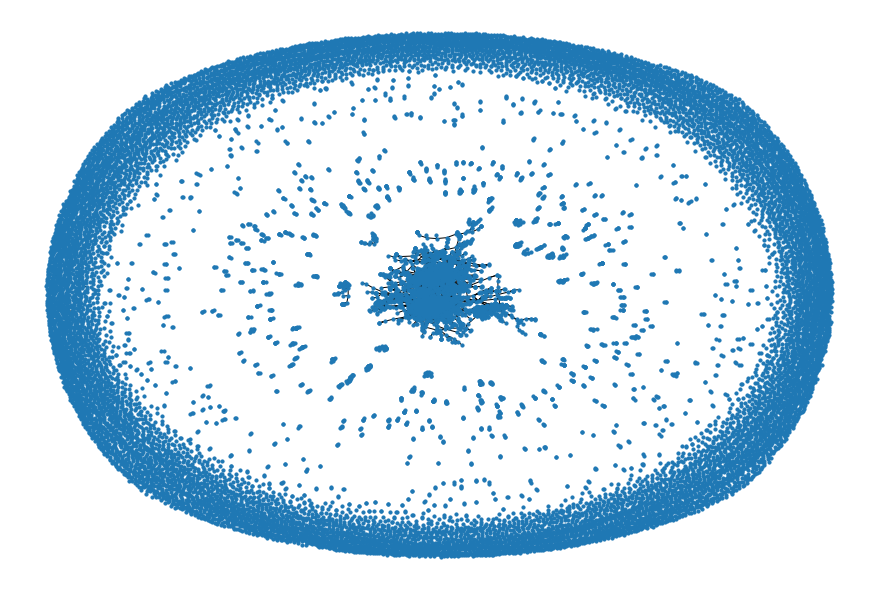

In [19]:
plt.figure(figsize=(12,8))
nx.draw(G, node_size=10)

In [73]:
len(G.edges)
# number of edges in the graph

9618

In [74]:
len(G.nodes)
# number of nodes in the graph 

18720

/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

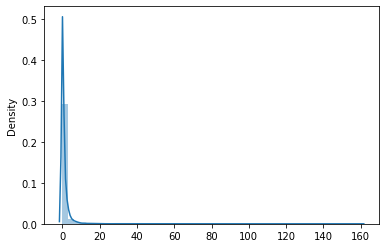

In [75]:
degrees = dict(G.degree).values()
sns.distplot([v for v in degrees])
# generate histogram of degrees of nodes 

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

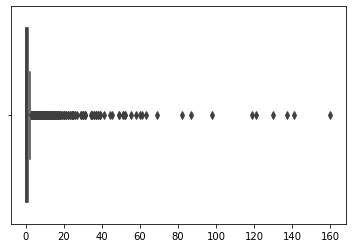

In [76]:
sns.boxplot([v for v in degrees])
# generate boxplot of degrees of nodes 

In [80]:
pd.Series(degrees).describe()
# statistical characteristics of the degrees of nodes 

count    18720.000000
mean         1.027564
std          3.848788
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max        160.000000
dtype: float64

In [87]:
pd.Series(degrees).sort_values(ascending = False).head(10)
# top-10 nodes with the highest degrees

8976     160
14962    141
6551     137
8185     130
9745     121
7531     119
8697      98
7317      87
7059      82
7337      69
dtype: int64

In [24]:
G.remove_edges_from(nx.selfloop_edges(G))
core_dec = nx.core_number(G)

In [25]:
max(core_dec.values())
# the largest core is 7 
# the maximum degrees of a nodes in a particular subnetwork is 7. 

7

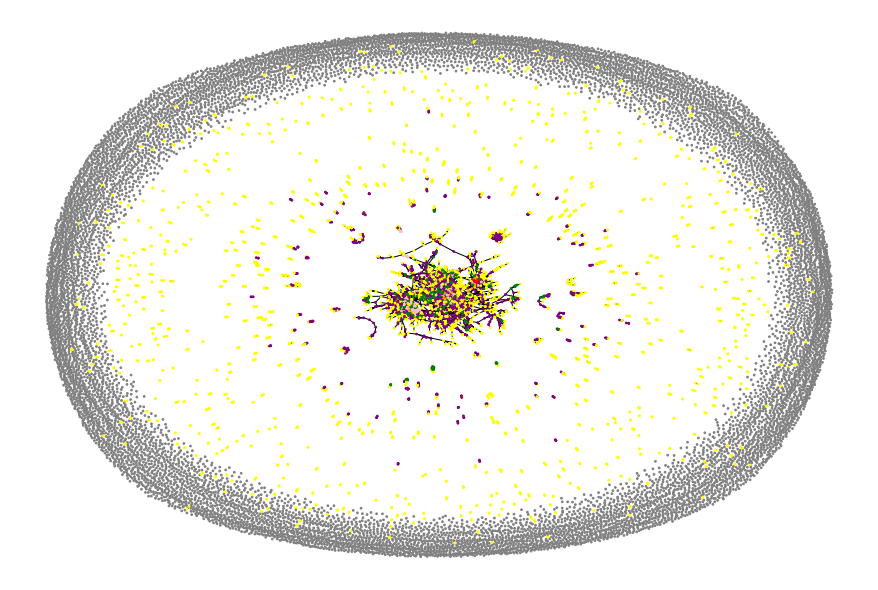

In [26]:
plt.figure(figsize=(12,8))
colors = ['red','blue','orange','pink','green', 'purple','yellow','grey']
colors.reverse()
node_colors = [colors[core_dec[v]] for v in G.nodes()]

nx.draw(G, node_color=node_colors, with_labels=False, node_size = 3)

## Model Building

In [94]:
'''
metrics function 

Input: 
truth - true labels
preds - predicted values 

The function returns a dictionary of various classification metrics, 
which includes precision, recall, and F-1 scores with macro average, 
as well as normalised mutural info score indicating the similarity 
of items within the cluster
'''
def metrics(truth, preds): 
    return {'precision': precision_score(truth, preds, average = 'macro'),\
           'recall': recall_score(truth, preds, average = 'macro'),\
           'f1': f1_score(truth, preds, average = 'macro'),\
           'NMI':normalized_mutual_info_score(truth, preds)}

### 1. Spectral Clustering

In [109]:
L = nx.laplacian_matrix(G).astype(float)
# encode the graph data into a laplacian matrix 

w, v = sp.sparse.linalg.eigsh(L, k = 5,which = 'SM')
# reduce the dimension of L and retrieve two vectors with the factor of 5

In [110]:
kmeans = KMeans(init='k-means++', n_clusters=5, n_init=10)
# configure KMeans object, identify 5 clusters in total 

kmeans.fit_predict(w*v)
# use the product of w*v (predicted L) and perform k-means clustering
preds = kmeans.labels_
truth = [label_dict[n] for n in G.nodes()]
# arrange the truth label array based on the nodes order 

In [111]:
spectralClusteringMetrics = metrics(truth, preds)
spectralClusteringMetrics

{'precision': 0.27235121419404806,
 'recall': 0.2797777833046944,
 'f1': 0.27061715811817083,
 'NMI': 0.14631812942018754}

In [31]:
tsne = TSNE(n_components=2, random_state=7, perplexity=15)
# fit the tsne model using the above created embeddings
embeddings_2d = tsne.fit_transform(w*v)
# create a 2 dimensional matrix for visualisation 

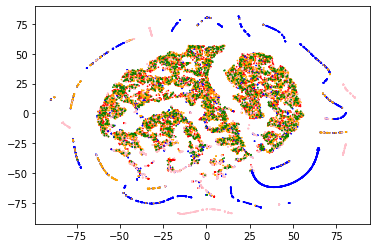

In [32]:
clusterColours = dict(zip([*range(0,5)], \
                   ['red','blue','orange','pink','green']))
label_df['colour'] = label_df['Labels'].apply(lambda x: clusterColours[x])
nodeColours = dict(zip(label_df['IDs'], label_df['colour']))
cols = [nodeColours[x] for x in nodeColours]
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c = cols, s = 0.5)

### 2. Random Walk Based Embeddings

In [112]:
node2vec = Node2Vec(G, dimensions=64, walk_length=30, \
                    num_walks=200, workers=4)
# configure the Node2Vec embedding 
# the returned matrices has the dimension of 64 
# walk length of 30 and 200 walks for each path and each node
model = node2vec.fit(window=10, min_count=1, batch_words=4)

In [113]:
actualNodes = [int(x) for x in model.wv.index_to_key]
# get the actual node ID of the vectors 
embeddings = np.array([model.wv[str(eachNode)] for eachNode in actualNodes])
# get the embeddings of respective nodes 
truth = [label_dict[i] for i in actualNodes]

In [114]:
kmeans = KMeans(init='k-means++', n_clusters=5, n_init=10)
kmeans.fit_predict(embeddings)
preds = kmeans.labels_

In [115]:
randomWalkMetrics = metrics(truth, preds)
randomWalkMetrics

{'precision': 0.22960760704638988,
 'recall': 0.0781813890091991,
 'f1': 0.08499032512491003,
 'NMI': 0.30843819037410697}

In [37]:
tsne = TSNE(n_components=2, random_state=7, perplexity=15)
# fit the tsne model using the above created embeddings
embeddings_2d = tsne.fit_transform(embeddings)

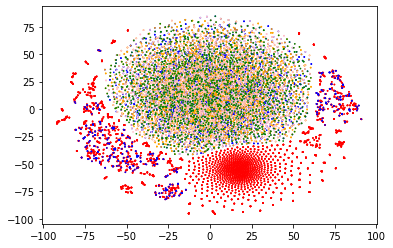

In [38]:
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c = cols, s = 0.5)

### 3. Text Embeddings

In [98]:
import nltk
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')
# create stopwords list 
stopword = set(stopwords.words('english'))

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/dahyekim/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/dahyekim/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/dahyekim/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [99]:
class RegexSNBTokenizer(object): 
    def __init__(self): 
        self.snb = SnowballStemmer('english')
        self.tokenizer = RegexpTokenizer(r"[a-zA-Z]+(?:[-'][a-zA-Z]+)?")
        self.__name__ = 'Regex_SNB'
        # initialise stemmer and tokenizer 
        # create .__name__ for latter use 
        
    def __call__(self, doc): 
        
        return [t.lower() for t in \
                [self.snb.stem(token) for token in self.tokenizer.tokenize(doc) \
                 if token not in stopword] \
                if len(t)>1
                # tokenize each word first, and stem it using snowball stemmer 
                # then from the list of tokens, filter out stopwords, tokens with length less than 1
                # change all the rest of the tokens into lower case 
               ]

In [100]:
vectorizerRegexSNBTokenizer = TfidfVectorizer(analyzer = 'word',\
                            input = 'content',\
                            ngram_range = (1,1),\
                            tokenizer = RegexSNBTokenizer())
# tf-idf vectoriser for classification 
# use only unigrams 

In [42]:
doc_dict_df.head(5)

,IDs,Docs
0,12828558,"Assessing Local Institutional Capacity, Data Availability, and Outcomes by"
1,66779408,THE PROSPECTS FOR INTERNET TELEPHONY IN EUROPE AND LATIN AMERICA TPP 127 Telecom Modeling and Policy Analysis
2,38902949,"Economic Shocks, Safety Nets, and Fiscal Constraints: Social Protection for the Poor in Latin America"
3,33450563,"Reform, Growth, and Poverty in Vietnam"
4,57470294,Households and Economic Growth in Latin America and the Caribbean


In [116]:
trainDoc = doc_dict_df['Docs'].tolist()
# put all documents into a list
vectorizerRegexSNBTokenizer.fit_transform(trainDoc)
# use tf-idf vectoriser with text pre-processing configurations 
embeddings = vectorizerRegexSNBTokenizer.transform(trainDoc)

In [117]:
kmeans = KMeans(init='k-means++', n_clusters=5, n_init=10)
# k = 5 k-means clustering configuration
kmeans.fit_predict(embeddings)
# fit the text-embedded data into clutering model
preds = kmeans.labels_
# obtain the labels predicted for each item 
truth = [label_dict[n] for n in doc_dict_df['IDs']]
# extract the true label from the label_dict dictionary 

In [118]:
textEmbeddingMetrics = metrics(truth, preds)
textEmbeddingMetrics

{'precision': 0.0565377422733125,
 'recall': 0.12022757474664818,
 'f1': 0.05199763080526885,
 'NMI': 0.16996371663274093}

In [46]:
tsne = TSNE(n_components=2, random_state=7, perplexity=15)
# fit the tsne model using the above created embeddings
embeddings_2d = tsne.fit_transform(embeddings)

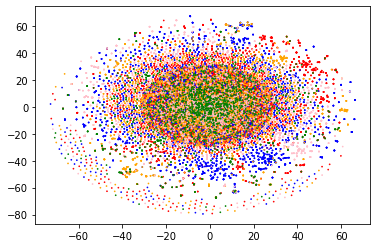

In [47]:
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c = cols, s = 0.5)

## Evaluating the Model using F-1 Score, Recall, Precision, and NMI

In [119]:
performance = pd.DataFrame([randomWalkMetrics, textEmbeddingMetrics, spectralClusteringMetrics], \
                           index = ['Node2Vec', 'TF-IDF','Spectral'])

In [120]:
performance

,precision,recall,f1,NMI
Node2Vec,0.229608,0.078181,0.084990,0.308438
TF-IDF,0.056538,0.120228,0.051998,0.169964
Spectral,0.272351,0.279778,0.270617,0.146318


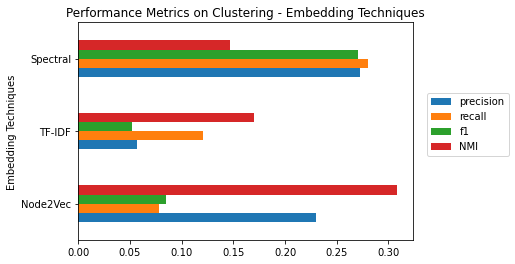

In [126]:
performance.plot.barh()
plt.ylabel('Embedding Techniques')
plt.title('Performance Metrics on Clustering - Embedding Techniques');
plt.legend(bbox_to_anchor=(1.3, 0.7))